In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [3]:
data.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [4]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
train, valid = train_test_split(data, test_size=0.1)

Y_train = train["label"]
X_train = train.drop(labels = ["label"], axis = 1)
X_train = X_train / 255.0

Y_valid = valid["label"]
X_valid = valid.drop(labels = ["label"], axis = 1)
X_valid = X_valid / 255.0

X_test = test / 255.0

In [7]:
# Data Augmentation and convertion to pytorch format (C, H, W)
transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
])

In [8]:
from torch.utils.data import Dataset

class MnistDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.Y[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, label


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train = torch.tensor(X_train.values.reshape(-1, 1, 28, 28)).to(device).float()
X_valid = torch.tensor(X_valid.values.reshape(-1, 1, 28, 28)).to(device).float()
X_test = torch.tensor(X_test.values.reshape(-1, 1, 28, 28)).to(device).float()

print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)

Y_train = F.one_hot(torch.tensor(Y_train.values), 10).float().to(device)
Y_valid = F.one_hot(torch.tensor(Y_valid.values), 10).float().to(device)

print(Y_train.shape)
print(Y_valid.shape)

torch.Size([37800, 1, 28, 28])
(37800,)
torch.Size([4200, 1, 28, 28])
(4200,)
torch.Size([28000, 1, 28, 28])
torch.Size([37800, 10])
torch.Size([4200, 10])


In [10]:
# hyper params
dropout_p = 0.4
learning_rate = 1e-3
batch_size = 256
models_count = 10
decay_rate = 0.95

In [11]:
# Datasets for tuning
train_dataset = MnistDataset(X_train, Y_train, transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset = TensorDataset(X_valid, Y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Dataset for full training and squeezing max perf
full_dataset = MnistDataset(torch.cat((X_train, X_valid), 0), torch.cat((Y_train, Y_valid), 0), transforms)
full_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# From https://arxiv.org/pdf/2001.08856v1.pdf
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(                   # Input (B, C, H, W) = (B,   1, 28, 28)
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),    # (B,  32, 26, 26)
            nn.ReLU(),                                                   # (B,  32, 26, 26)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),   # (B,  64, 24, 24)
            nn.ReLU(),                                                   # (B,  64, 24, 24)
            nn.MaxPool2d(kernel_size=2, stride=2),                       # (B,  64, 12, 12)
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),  # (B, 128, 10, 10)
            nn.ReLU(),                                                   # (B, 128, 10, 10)
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3), # (B, 256,  8,  8)
            nn.ReLU(),                                                   # (B, 256,  8,  8)
            nn.MaxPool2d(kernel_size=2, stride=2),                       # (B, 256,  4,  4)
            
            nn.Flatten(),                                                # (B, 4_096)
            
            nn.Linear(in_features=4_096, out_features=1_024),            # (B, 1_024)
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(in_features=1_024, out_features=128),              # (B,   128)
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(in_features=128, out_features=10),                 # (B,    10) = Output Layer
        )
        
    def forward(self, x):
        return self.net(x)

In [13]:
def train(model, optimizer, data_loader, epoch, log=False):
    model.train()
    correct = 0
    total = 0
    for x, y in data_loader:
        optimizer.zero_grad()
        out = model(x)
        loss = F.cross_entropy(out, y)
        loss.backward()
        optimizer.step()
        pred = out.argmax(dim=-1)
        target = y.argmax(dim=-1)
        correct += (pred == target).sum().item()
        total += target.shape[0]
        
    accuracy = correct / total * 100.0
    if log:
        print(f"Epoch {epoch}: Train loss {loss.item()}, Train accuracy {correct}/{total} = {accuracy}")
    return loss.item(), accuracy

In [14]:
def validate(model, data_loader, epoch, log=False):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in data_loader:
            out = model(x)
            loss = F.cross_entropy(out, y)
            pred = out.argmax(dim=-1)
            target = y.argmax(dim=-1)
            correct += (pred == target).sum().item()
            total += target.shape[0]
        
    accuracy = correct / total * 100.0
    if log:
        print(f"Epoch {epoch}: Validation loss {loss.item()}, Validation accuracy {correct}/{total} = {accuracy}")
    return loss.item(), accuracy

In [15]:
def training_loop(model, optimizer, train_loader, scheduler, total_epochs, validation_loader=None):
    training_loss_history = []
    training_accuracy_history = []
    validation_loss_history = []
    training_accuracy_history = []
    for epoch in range(1, total_epochs + 1):
        training_loss, training_accuracy = train(model, optimizer, train_loader, epoch)
        training_loss_history.append(training_loss)
        training_accuracy_history.append(training_accuracy)
        
        if validation_loader:
            validation_loss, validation_accuracy = validate(model, validation_loader, epoch)
            validation_loss_history.append(validation_loss)
            training_accuracy_history.append(validation_accuracy)

        scheduler.step()
        
        if validation_loader:
            print(f"Epoch [{epoch}/{total_epochs}]: Training Loss {training_loss}, Validation Accuracy {validation_accuracy}")
        else:
            print(f"Epoch [{epoch}/{total_epochs}]: Loss {training_loss}, Accuracy {training_accuracy}")
    return training_loss_history, training_accuracy_history, validation_loss_history, training_accuracy_history

In [16]:
def ensemble(num_models=10):
    models = [Model().to(device) for _ in range(num_models)]
    return models

def train_ensemble(models, train_loader, total_epochs, validation_loader=None):
    for i, model in enumerate(models):
        print(f"\n===================== MODEL [{i+1}/{len(models)}] =====================\n")
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, decay_rate)
        histories = training_loop(model, optimizer, train_loader, scheduler, total_epochs, valid_loader) # When validating
#         histories = training_loop(model, optimizer, full_loader, scheduler, total_epochs) # Full training to squeeze perf
        fig, ax = plt.subplots()
        ax.plot(histories[0], label="Training Loss")
        ax.plot(histories[2], label="Validation Loss")
        ax.set_title(f"Model {i+1}'s Losses history")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

        fig, ax = plt.subplots()
        ax.plot(histories[1], label="Training Accuracy")
        ax.plot(histories[3], label="Validation Accuracy")
        ax.set_title(f"Model {i+1}'s Accuracy history")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        ax.legend()
        

In [17]:
def make_predictions_single_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []

    with torch.no_grad():  # Disable gradient computation
        for batch in test_loader:
            inputs = batch[0].to(device)  # Move inputs to GPU
            outputs = model(inputs)
            preds = F.softmax(outputs, dim=-1)
            all_preds.append(preds)

    # Concatenate all predictions
    all_preds = torch.cat(all_preds, dim=0)
    return all_preds

In [18]:
def predict_ensemble(models, test_loader):
    predictions = [make_predictions_single_model(model, test_loader) for model in models]
    predictions = sum(predictions)
    return predictions.argmax(dim=-1)


===================== MODEL [1/10] =====================

Epoch [1/50]: Training Loss 0.2914312183856964, Validation Accuracy 96.78571428571429
Epoch [2/50]: Training Loss 0.14328652620315552, Validation Accuracy 98.19047619047619
Epoch [3/50]: Training Loss 0.11966771632432938, Validation Accuracy 98.66666666666667
Epoch [4/50]: Training Loss 0.11994112282991409, Validation Accuracy 98.78571428571429
Epoch [5/50]: Training Loss 0.11265751719474792, Validation Accuracy 99.19047619047619
Epoch [6/50]: Training Loss 0.07983868569135666, Validation Accuracy 98.90476190476191
Epoch [7/50]: Training Loss 0.12422752380371094, Validation Accuracy 99.38095238095238
Epoch [8/50]: Training Loss 0.07954388111829758, Validation Accuracy 99.09523809523809
Epoch [9/50]: Training Loss 0.034609030932188034, Validation Accuracy 99.26190476190476
Epoch [10/50]: Training Loss 0.03170846775174141, Validation Accuracy 99.47619047619047
Epoch [11/50]: Training Loss 0.025292567908763885, Validation Accuracy

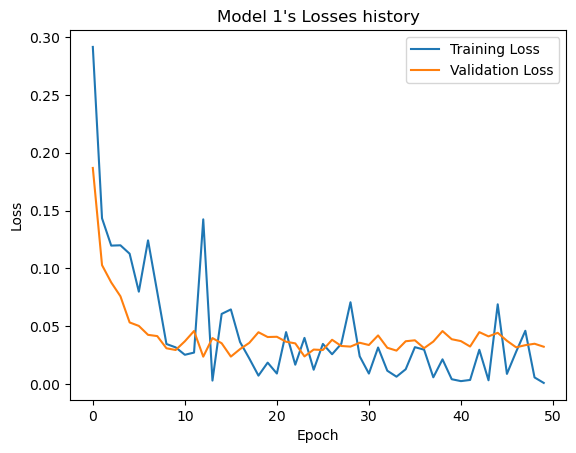

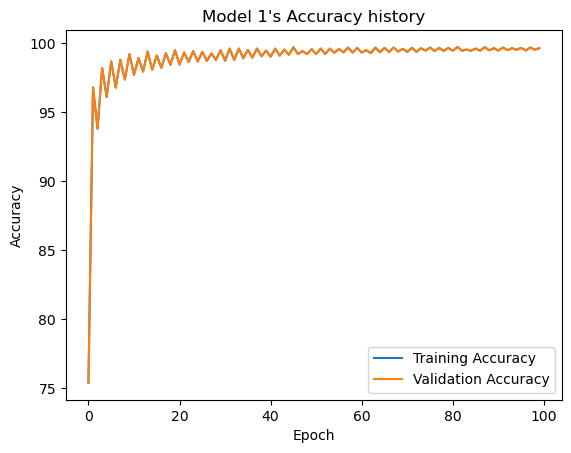

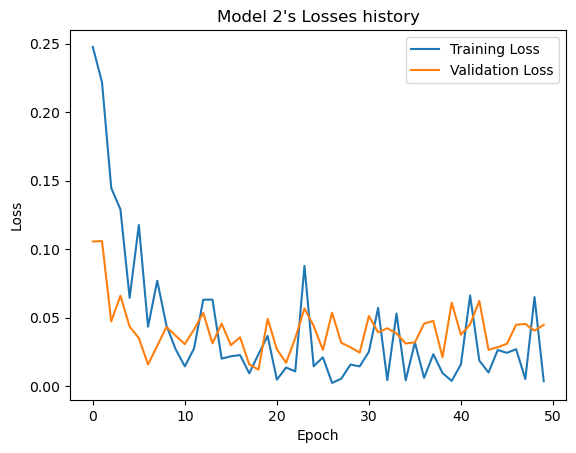

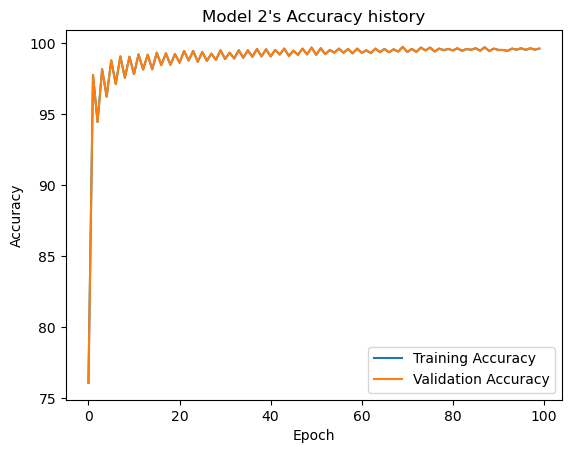

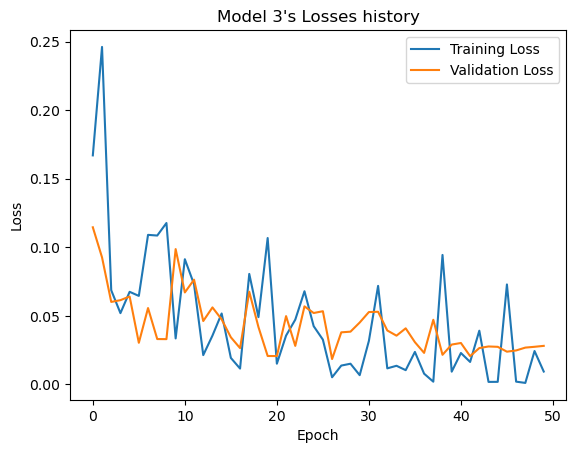

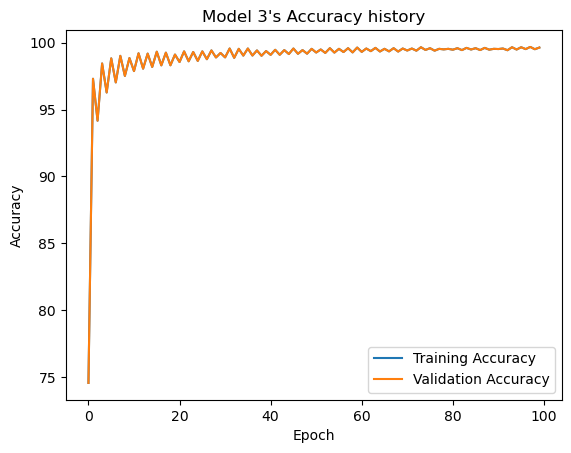

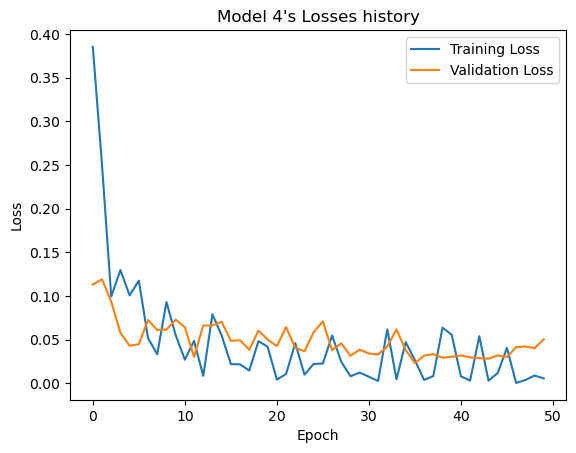

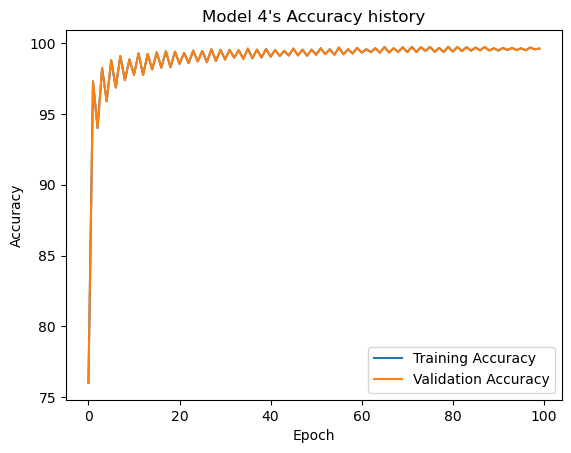

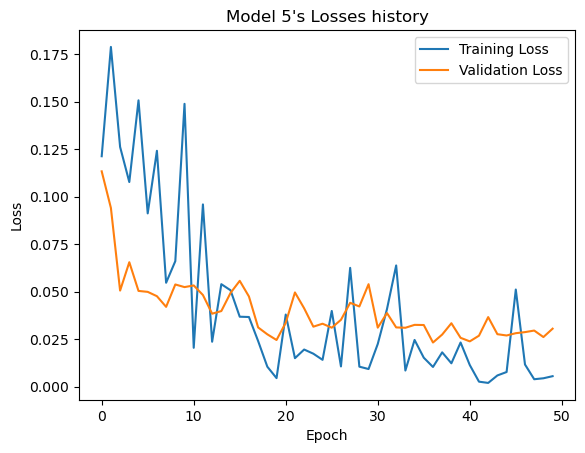

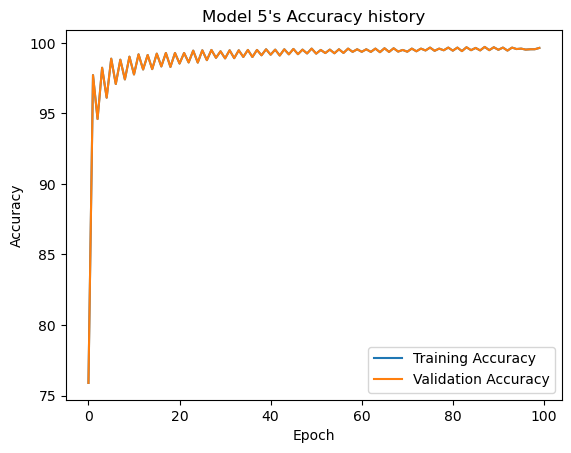

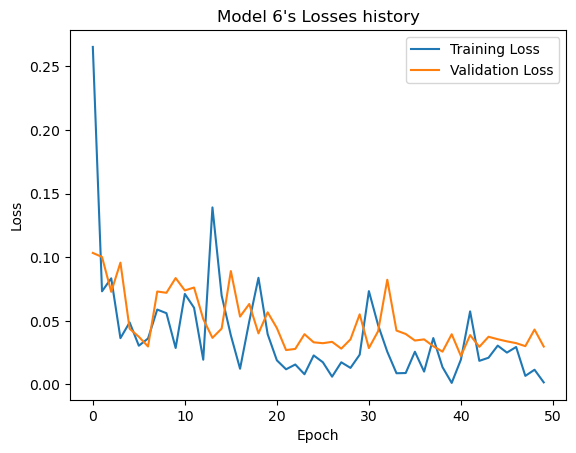

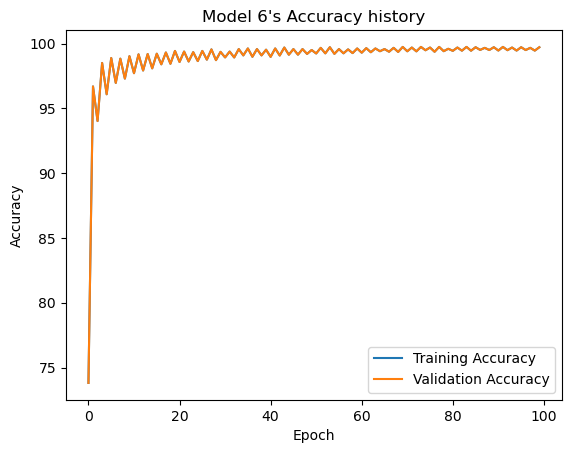

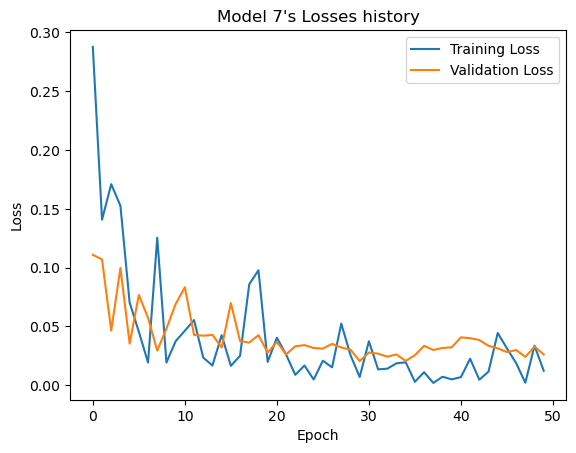

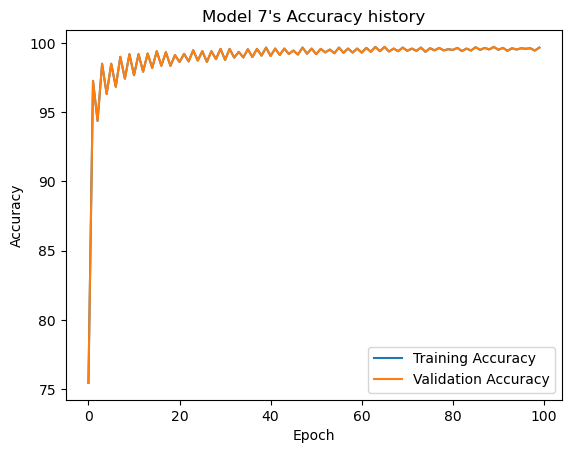

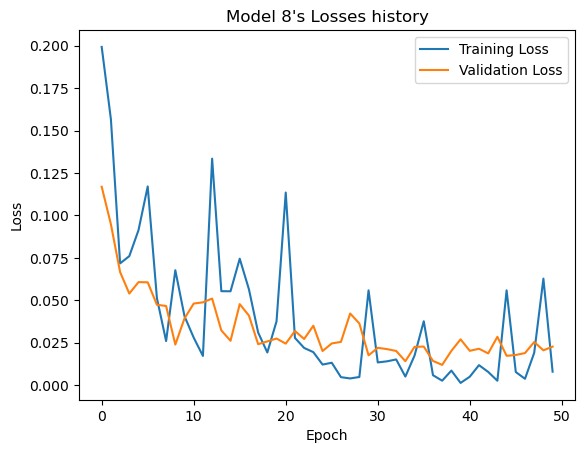

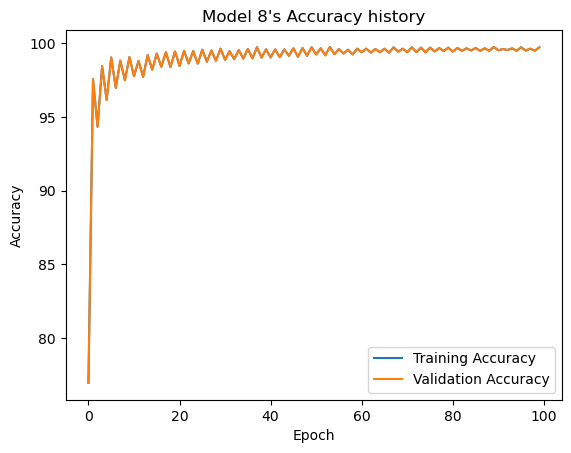

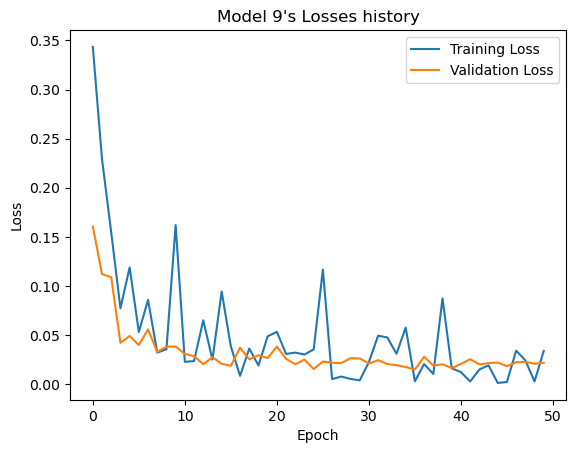

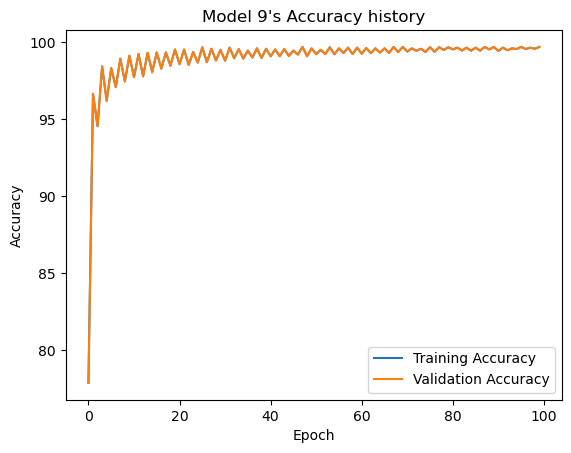

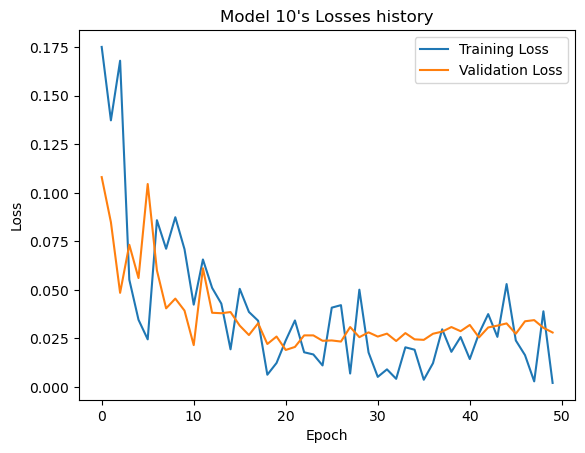

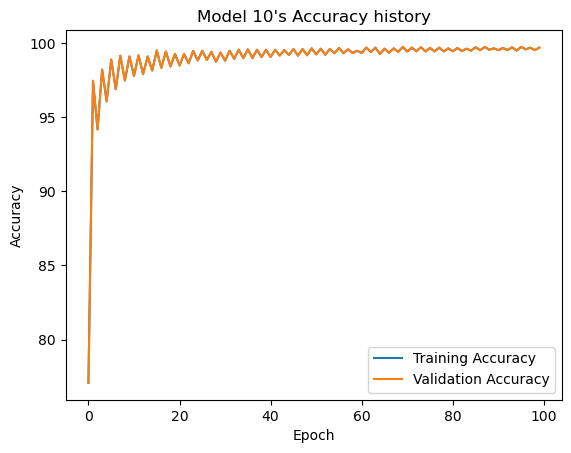

In [19]:
models = ensemble(models_count)
train_ensemble(models, full_loader, 50)

In [20]:
def validate_ensemble(models, valid_loader, Y_valid):
    all_preds = predict_ensemble(models, valid_loader)
    accuracy = (all_preds == Y_valid.argmax(dim=-1)).sum() / len(all_preds) * 100.0
    return accuracy

In [21]:
accuracy = validate_ensemble(models, valid_loader, Y_valid) # Not that when trainging with full train set, this has been contaminated
print(accuracy)

tensor(99.7143, device='cuda:0')


In [22]:
all_preds = predict_ensemble(models, test_loader)

In [23]:
print(all_preds.shape, all_preds[:10])

torch.Size([28000]) tensor([2, 0, 9, 0, 3, 7, 0, 3, 0, 3], device='cuda:0')


In [24]:
out = pd.DataFrame({"ImageId": np.arange(1, len(all_preds) + 1), "Label": all_preds.cpu().numpy()})

In [25]:
out.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [26]:
out.tail()

,ImageId,Label
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2


In [27]:
out.to_csv('submission.csv', index=False)